# Goal

Implement electricity demand forecasting with Gradient Boosting (XGBoost) ensemble tree method.

- Perform timeseries cross validation
- Leave 7-day window at end so there's always a test set

# Import Packages

Third-Pary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import seaborn as sns
import sys
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

My core package:

In [2]:
sys.path.append('../')
from core.data import add_temporal_features

# Data

In [3]:
# Import Data
df = pd.read_csv('eia_api_pjm_demand.csv')

# Cast column types
df['utc_ts'] = pd.to_datetime(df['utc_ts'], utc=True)
df = df.set_index('utc_ts')
df['D'] = pd.to_numeric(df['D'])
df['DF'] = pd.to_numeric(df['DF'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78840 entries, 2015-07-01 05:00:00+00:00 to 2024-06-28 04:00:00+00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   respondent  78834 non-null  object 
 1   D           78667 non-null  float64
 2   DF          78551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.4+ MB


# Outlier Detection and Capping

Plotting a histogram of the data shows all the data squished into a tiny bin. Clearly there must be an enourmous outlier.

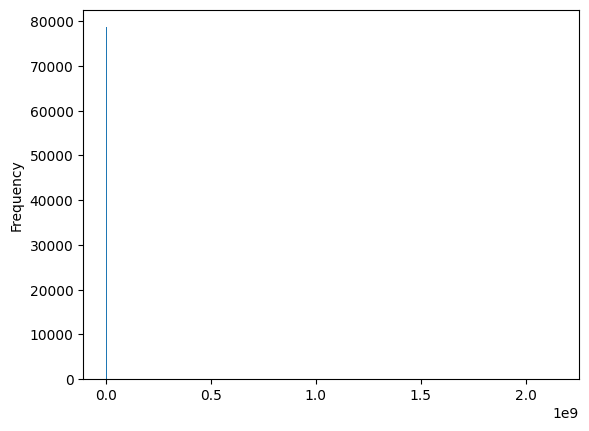

In [4]:
df.D.plot(kind='hist', bins=500)
plt.show()

Tweak and upper and lower threshold to find a reasonably small number of outliers.

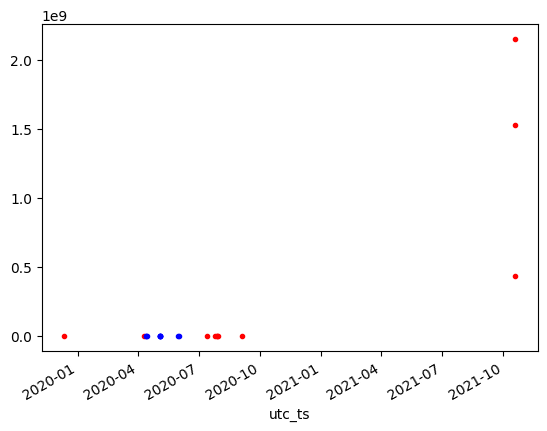

Number of upper outliers: 11
Number of lower outliers: 10


In [5]:
MAX_D_VAL = 165_000
MIN_D_VAL = 60_000
#upper_outliers = df.query(f'D > {MAX_D_VAL}')['D']
#lower_outliers = df.query(f'(D < {MIN_D_VAL})')['D']
upper_outliers = df[df.D > MAX_D_VAL].D
lower_outliers = df[df.D < MIN_D_VAL].D
upper_outliers.plot(style='.', color='r')
lower_outliers.plot(style='.', color='b')
plt.show()

print(f'Number of upper outliers: {len(upper_outliers)}')
print(f'Number of lower outliers: {len(lower_outliers)}')

<Axes: ylabel='Frequency'>

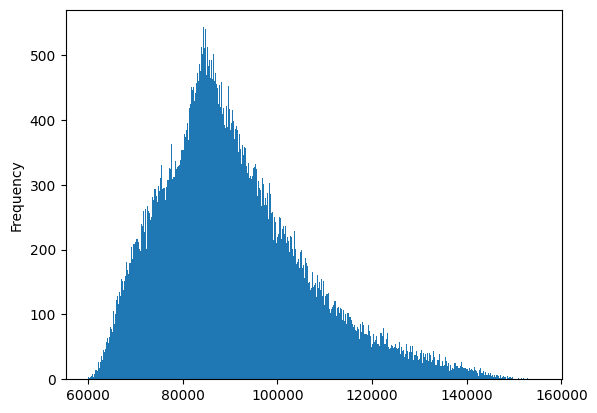

In [6]:
df[(df.D > MIN_D_VAL) & (df.D < MAX_D_VAL)].D.plot(kind='hist', bins=500)

Let's cap the outliers

In [7]:
df.loc[df.D < MIN_D_VAL, 'D'] = MIN_D_VAL
df.loc[df.D > MAX_D_VAL, 'D'] = MAX_D_VAL

## Null value imputation

In [8]:
print(f'Number of null demand values: {sum(df.D.isnull())}')

Number of null demand values: 173


__Q__: Where do the null values occur?

__A__: Below we see that, across multiple years, most null values occur either early in the year (somewhere around day 40) or late in the year (somewhere around day 310).

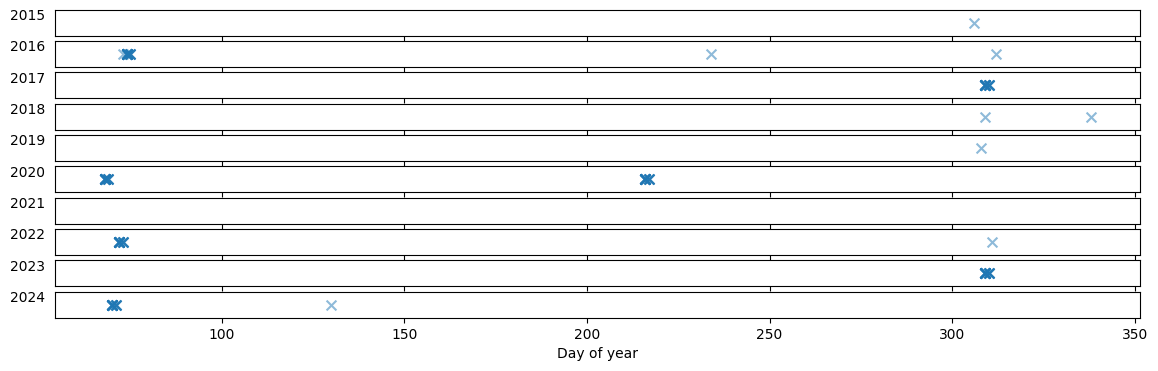

In [9]:
start_year = df.index.min().year
end_year = df.index.max().year
num_years = end_year - start_year + 1
fig, ax = plt.subplots(num_years, 1, figsize=(14, 4), sharex=True)
for i in range(num_years):
    year = start_year + i
    year_df = df[df.index.year == year]
    null_D = year_df.D.isnull().astype(int)
    null_D[null_D == 0] = np.nan
    ax[i].scatter(year_df.index.dayofyear, null_D, s=50.0, alpha=0.5, marker='x')
    ax[i].set_ylabel(year, rotation='horizontal', labelpad=20)
    ax[i].set_yticks([])
    ax[i].set_xlabel('Day of year')
plt.show()

Let's impute the null values as the average demand value for the given month and hour:

In [10]:
from collections import defaultdict
avg_D_by_month_hour = defaultdict(dict)
for month in np.arange(1, 12+1):
    for hour in np.arange(24):
        month_mask = df.index.month == month
        hour_mask = df.index.hour == hour
        avg_D_by_month_hour[month][hour] = df[month_mask & hour_mask].D.mean()

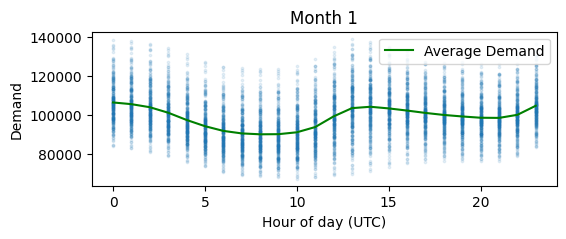

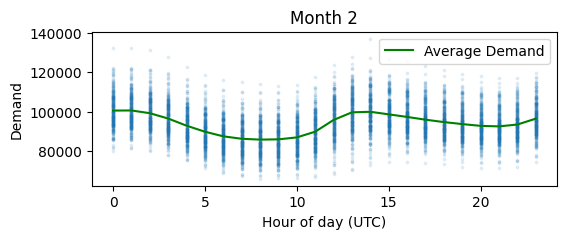

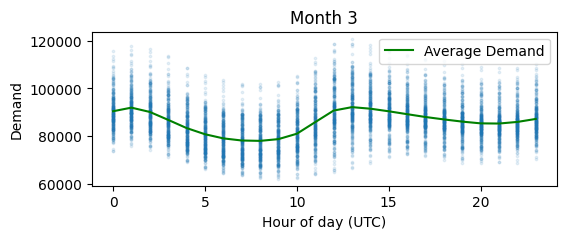

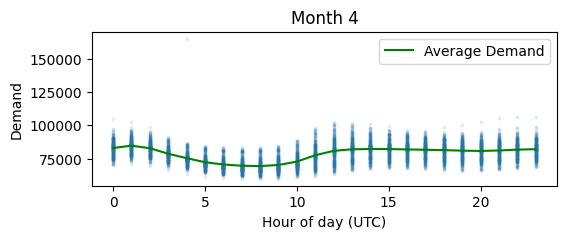

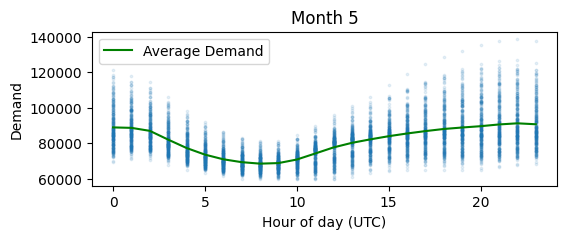

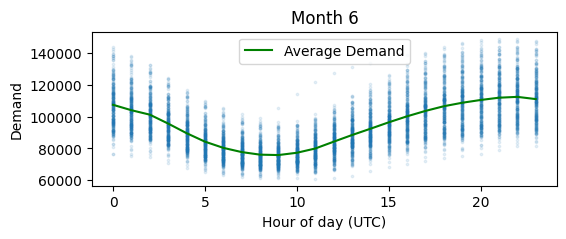

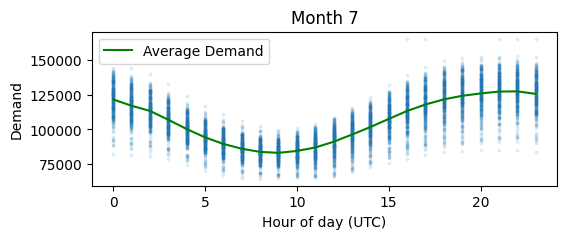

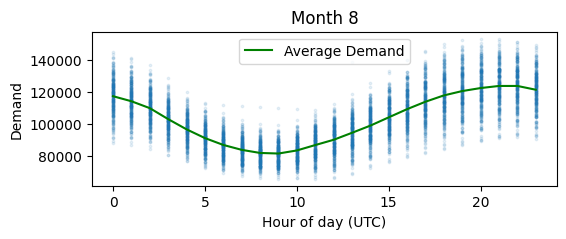

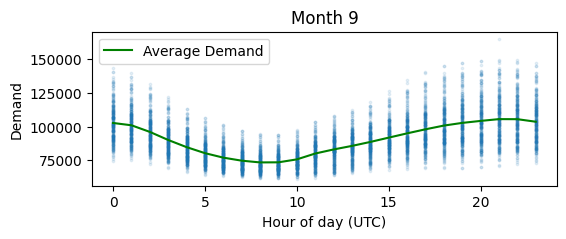

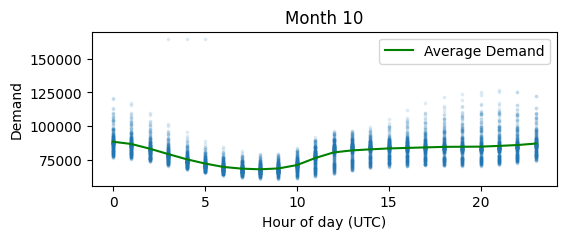

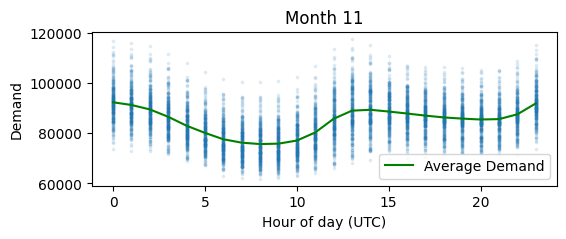

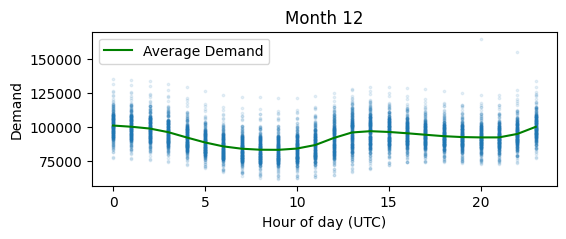

In [12]:
for month in np.arange(1, 12+1):
    avg_by_hour = avg_D_by_month_hour[month]
    temps = list(map(lambda h: avg_by_hour[h], np.arange(24)))
    month_df = df[df.index.month == month]
    fig, ax = plt.subplots(figsize=(6,2))
    plt.scatter(month_df.index.hour, month_df.D, s=3.0, alpha=0.1)
    plt.plot(np.arange(24), temps, color='g', label='Average Demand')
    plt.title(f'Month {month}')
    plt.xlabel('Hour of day (UTC)')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

In [23]:
def impute_null_demand_value(row):
    month, hour = row.name.month, row.name.hour
    return avg_D_by_month_hour[month][hour]

null_mask = df.D.isnull()
df['D'] = df.apply(lambda row: impute_null_demand_value(row) if pd.isnull(row['D']) else row['D'], axis=1)

assert sum(df.D.isnull()) == 0

# Timeseries Cross Validation

For timeseries, our K-fold cross validation splits must still preserve the sequential nature of our dataset (test set must always be later in time than training).

## Create and Visualize the train/test splits

In [25]:
# 1 week in hours
TEST_SET_SIZE = 7 * 24
NUM_SPLITS = 5

In [26]:
tss = TimeSeriesSplit(n_splits=NUM_SPLITS, test_size=TEST_SET_SIZE)
print(tss)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=168)


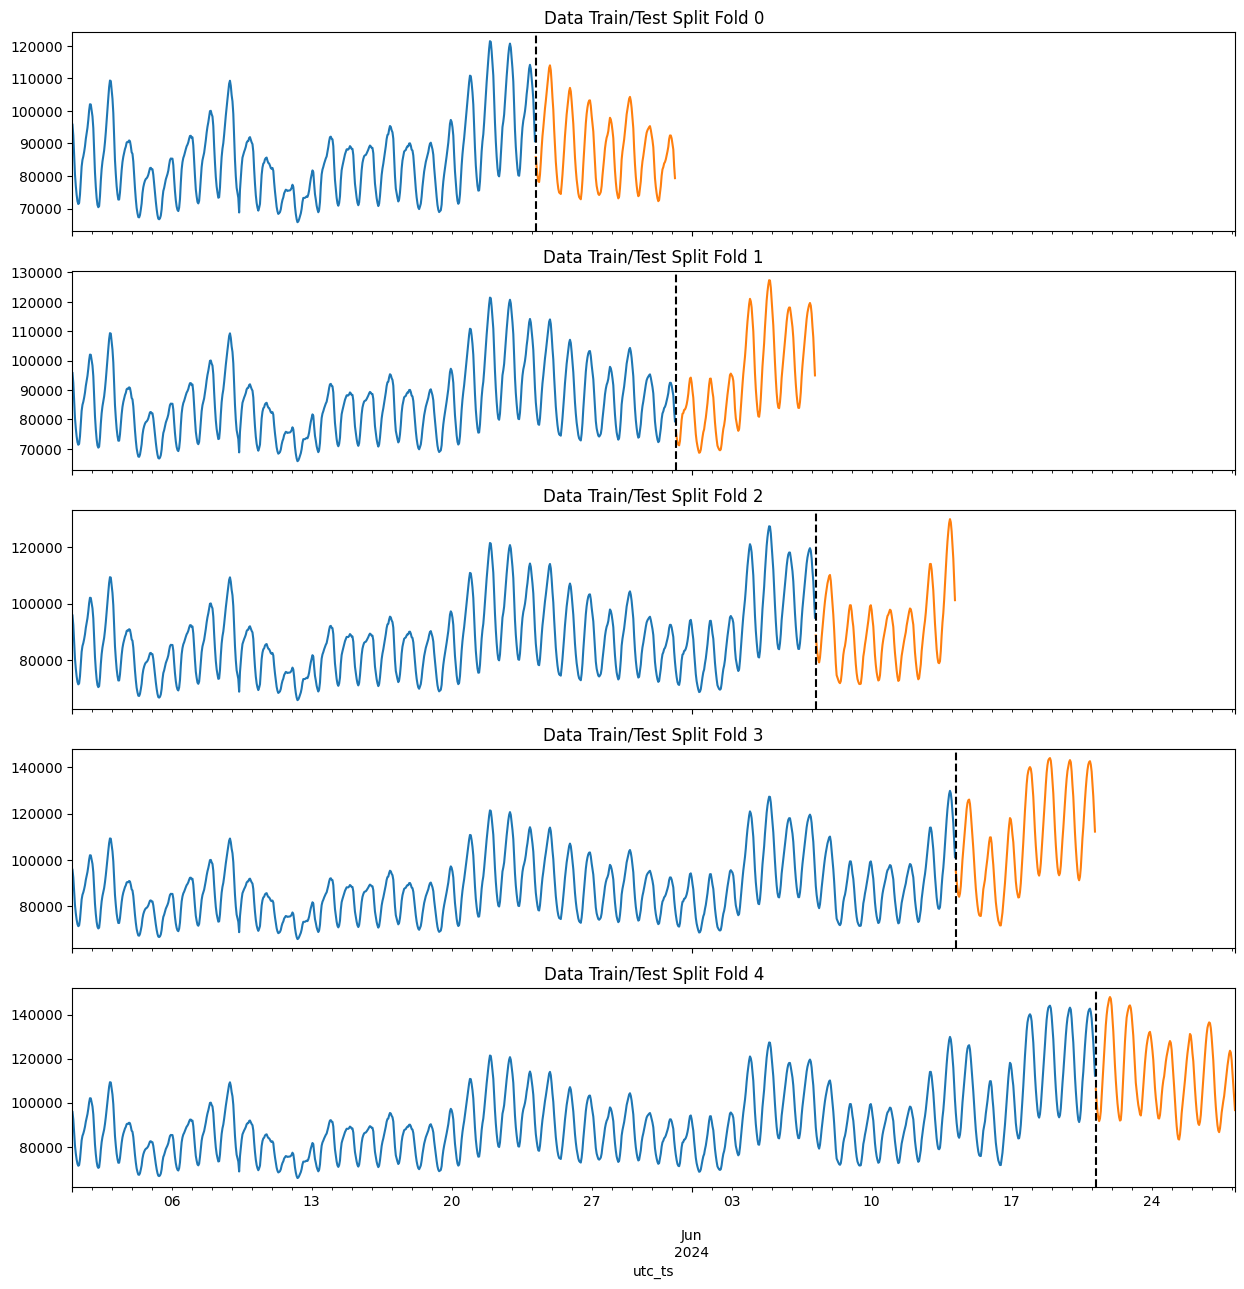

In [27]:
fig, axs = plt.subplots(NUM_SPLITS, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    # Cut out bulk of common training data for better visualization
    train = train[train.index > '05-01-2024']
    train['D'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['D'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
plt.show()

# Feature Engineering

In [28]:
df = add_temporal_features(df)

In [29]:
df.head()

,respondent,D,DF,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,,,
2015-07-01 05:00:00+00:00,PJM,84024.0,29415.0,5,7,2015,3,2,1,182
2015-07-01 06:00:00+00:00,PJM,79791.0,27687.0,6,7,2015,3,2,1,182
2015-07-01 07:00:00+00:00,PJM,76760.0,26574.0,7,7,2015,3,2,1,182
2015-07-01 08:00:00+00:00,PJM,74931.0,26029.0,8,7,2015,3,2,1,182
2015-07-01 09:00:00+00:00,PJM,74368.0,26220.0,9,7,2015,3,2,1,182


# References
- https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook